In this notebook, we test out hyperparameter tuning with Optuna. again. with GNBlocks and only 5 edges per node. 200 epochs

### imports and setup

In [58]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of utils.lorenz failed: Traceback (most recent call last):
  File "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/lorenzvenv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/lorenzvenv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 484, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/lorenzvenv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 381, in update_generic
    update(a, b)
  File "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/lorenzvenv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    update_instances(old, new)
  File "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/lorenzvenv/lib/python3.9/site-packages/IPython/extensions/autorel

In [ ]:
from utils.jraph_training import train_and_evaluate_with_data, create_dataset
# from utils.jraph_models import MLPGraphNetwork
from utils.jraph_data import print_graph_fts
from utils.jraph_vis import plot_predictions
from utils.hyperparam_tuning import remove_bad_trials, get_best_trial_config, get_best_trial_workdir
import ml_collections
import optuna 
from flax import linen as nn
from functools import partial
from datetime import datetime
import os 

In [ ]:
# set up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

### set up functions for optuna

In [ ]:
CHECKPOINT_PATH = "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/experiments/tuning"

In [ ]:
def objective(trial, study_name, datasets):
    """ Defines the objective function to be optimized over, aka the validation loss of a model.
    
        Args:
            trial: object which characterizes the current run 
            datasets: dictionary of data. we explicitly pass this in so that we don't have to waste runtime regenerating the same dataset over and over. 
    """
    # create config 
    config = ml_collections.ConfigDict()

    # Optimizer.
    # config.optimizer = "adam"
    config.optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd"])
    config.learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-2, 
                                               log=True)
    if config.optimizer == "sgd":
        config.momentum = trial.suggest_float('momentum', 0, 0.999) # upper bound is inclusive, and we want to exclude a momentum of 1 because that would yield no decay 

    # Data params that are used in training 
    config.output_steps = 4

    # Training hyperparameters.
    config.batch_size = 1 # variable currently not used
    config.epochs = 200
    config.log_every_epochs = 5
    config.eval_every_epochs = 5
    config.checkpoint_every_epochs = 10

    # GNN hyperparameters.
    config.model = 'MLPBlock'
    config.dropout_rate = trial.suggest_float('dropout_rate', 0, 0.6)
    config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
    config.layer_norm = False # TODO perhaps we want to turn on later
    config.activation = trial.suggest_categorical(
        'activation', ["relu", "elu", "leaky_relu"])
    
    # choose the hidden layer feature size using powers of 2 
    config.edge_features = (
        2**trial.suggest_int("edge_mlp_1_power", 1, 3), # range 2 - 8; upper bound is inclusive
        2**trial.suggest_int("edge_mlp_2_power", 1, 3), # range 2 - 8
    )
    config.node_features = (
        2**trial.suggest_int("node_mlp_1_power", 1, 8), # range 2 - 512
        2**trial.suggest_int("node_mlp_2_power", 1, 8), # range 2 - 512
        2) 
    # note the last feature size will be the number of features that the graph predicts
    config.global_features = None

    # generate a workdir 
    # TODO: check if we actually care about referencing this in the future or if we can just create a temp dir 
    workdir=os.path.join(CHECKPOINT_PATH, study_name, f"trial_{trial.number}")

    # run training 
    state, train_metrics, eval_metrics_dict = train_and_evaluate_with_data(config=config, workdir=workdir, datasets=datasets, trial=trial)
    
    # retrieve and return val loss (MSE)
    # print("eval_metrics_dict['val'].loss", eval_metrics_dict['val'].loss)
    # print("eval_metrics_dict['val'].compute()['loss']", eval_metrics_dict['val'].compute()['loss'])
    # print()
    return eval_metrics_dict['val'].compute()['loss']




In [ ]:
def get_data_config():
    config = ml_collections.ConfigDict()

    config.n_samples=10_000
    config.input_steps=1
    config.output_delay=8 # predict 24 hrs into the future 
    config.output_steps=4
    config.timestep_duration=3 # equivalent to 3 hours
    # note a 3 hour timestep resolution would be 5*24/3=40
    # if the time_resolution is 120, then a sampling frequency of 3 would achieve a 3 hour timestep 
    config.sample_buffer = -1 * (config.input_steps + config.output_delay + config.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
        # number of timesteps strictly between the end 
        # of one full sample and the start of the next sample
    config.time_resolution=120 # the number of 
                # raw data points generated per time unit, equivalent to the 
                # number of data points generated per 5 days in the simulation
    config.init_buffer_samples=100
    config.train_pct=0.7
    config.val_pct=0.2
    config.test_pct=0.1
    config.K=36
    config.F=8
    config.c=10
    config.b=10
    config.h=1
    config.seed=42
    config.normalize=True
    config.fully_connected_edges=False

    return config

In [ ]:
def prepare_study(study_name):
    # generate dataset 
    dataset_config = get_data_config()
    datasets = create_dataset(dataset_config)
    print_graph_fts(datasets['train']['inputs'][0][0])

    # get the objective function that reuses the pre-generated datasets 
    objective_partial = partial(objective, study_name=study_name, 
                                datasets=datasets)

    # run optimization study
    db_path = os.path.join(CHECKPOINT_PATH, study_name, "optuna_hparam_search.db")
    if not os.path.exists(os.path.join(CHECKPOINT_PATH, study_name)):
        os.makedirs(os.path.join(CHECKPOINT_PATH, study_name))

    study = optuna.create_study(
        study_name=study_name,
        storage=f'sqlite:///{db_path}', # generates a new db if it doesn't exist
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5, 
            n_warmup_steps=50,
            ), 
        load_if_exists=True, 
    )
    
    return study, objective_partial

### hyperparameter tuning 

In [8]:
# get study
study11, objective_partial = prepare_study(study_name="hparam_study_11")

Number of nodes: 36
Number of edges: 180
Node features shape: (36, 2)
Edge features shape: (180, 1)
Global features shape: (1, 1)


[I 2023-12-01 22:32:26,842] Using an existing study with name 'hparam_study_11' instead of creating a new one.


In [10]:
study11.optimize(objective_partial, 
                n_trials=5-len(study11.trials), 
                n_jobs=1)

[I 2023-12-01 23:09:34,440] Trial 1 finished with value: 7209700864.0 and parameters: {'optimizer': 'adam', 'learning_rate': 0.027183171314990096, 'dropout_rate': 0.1957062510293844, 'activation': 'elu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 3, 'node_mlp_2_power': 7}. Best is trial 1 with value: 7209700864.0.
[I 2023-12-01 23:43:23,131] Trial 2 finished with value: 0.956436276435852 and parameters: {'optimizer': 'adam', 'learning_rate': 0.007021867326771341, 'dropout_rate': 0.21469056683685872, 'activation': 'leaky_relu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 6, 'node_mlp_2_power': 8}. Best is trial 2 with value: 0.956436276435852.
[I 2023-12-01 23:57:08,340] Trial 3 finished with value: 0.7636350393295288 and parameters: {'optimizer': 'adam', 'learning_rate': 0.00031183725136864793, 'dropout_rate': 0.27780686749472755, 'activation': 'leaky_relu', 'edge_mlp_1_power': 1, 'edge_mlp_2_power': 1, 'node_mlp_1_power': 3, 'node_mlp_2_pow

Exception: training losses for this graph are nan; aborting now

ok it's weird that we are occasionally still getting huge errors like in trial 0

In [12]:
study11.trials

[FrozenTrial(number=0, state=TrialState.FAIL, values=None, datetime_start=datetime.datetime(2023, 12, 1, 22, 30, 48, 151214), datetime_complete=datetime.datetime(2023, 12, 1, 22, 31, 7, 60856), params={'optimizer': 'sgd', 'learning_rate': 0.004936404948088913, 'momentum': 0.19641629162070173, 'dropout_rate': 0.2127739178404181, 'activation': 'leaky_relu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 1, 'node_mlp_1_power': 5, 'node_mlp_2_power': 6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'optimizer': CategoricalDistribution(choices=('adam', 'sgd')), 'learning_rate': FloatDistribution(high=0.05, log=True, low=0.0001, step=None), 'momentum': FloatDistribution(high=0.999, log=False, low=0.0, step=None), 'dropout_rate': FloatDistribution(high=0.6, log=False, low=0.0, step=None), 'activation': CategoricalDistribution(choices=('relu', 'elu', 'leaky_relu')), 'edge_mlp_1_power': IntDistribution(high=3, log=False, low=1, step=1), 'edge_mlp_2_power': IntDistribution(

let's plot the best trial predictions so far

In [14]:
datasets = create_dataset(get_data_config())

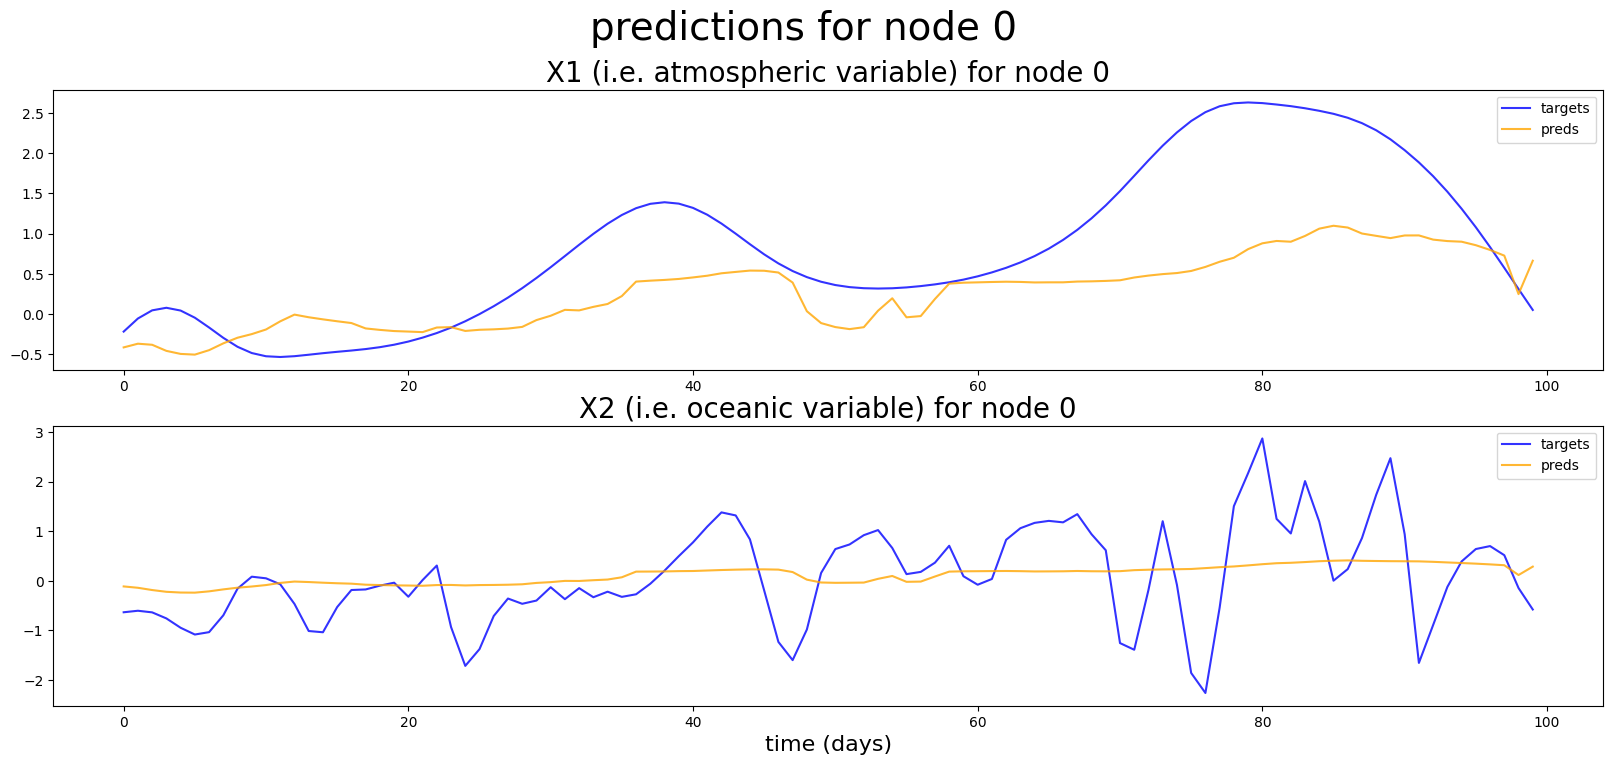

In [15]:
plot_predictions(
    config=get_best_trial_config(study=study11),
    workdir=get_best_trial_workdir(study=study11), # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=datasets,
    plot_all=False, # if false, only plot the first 100 
)

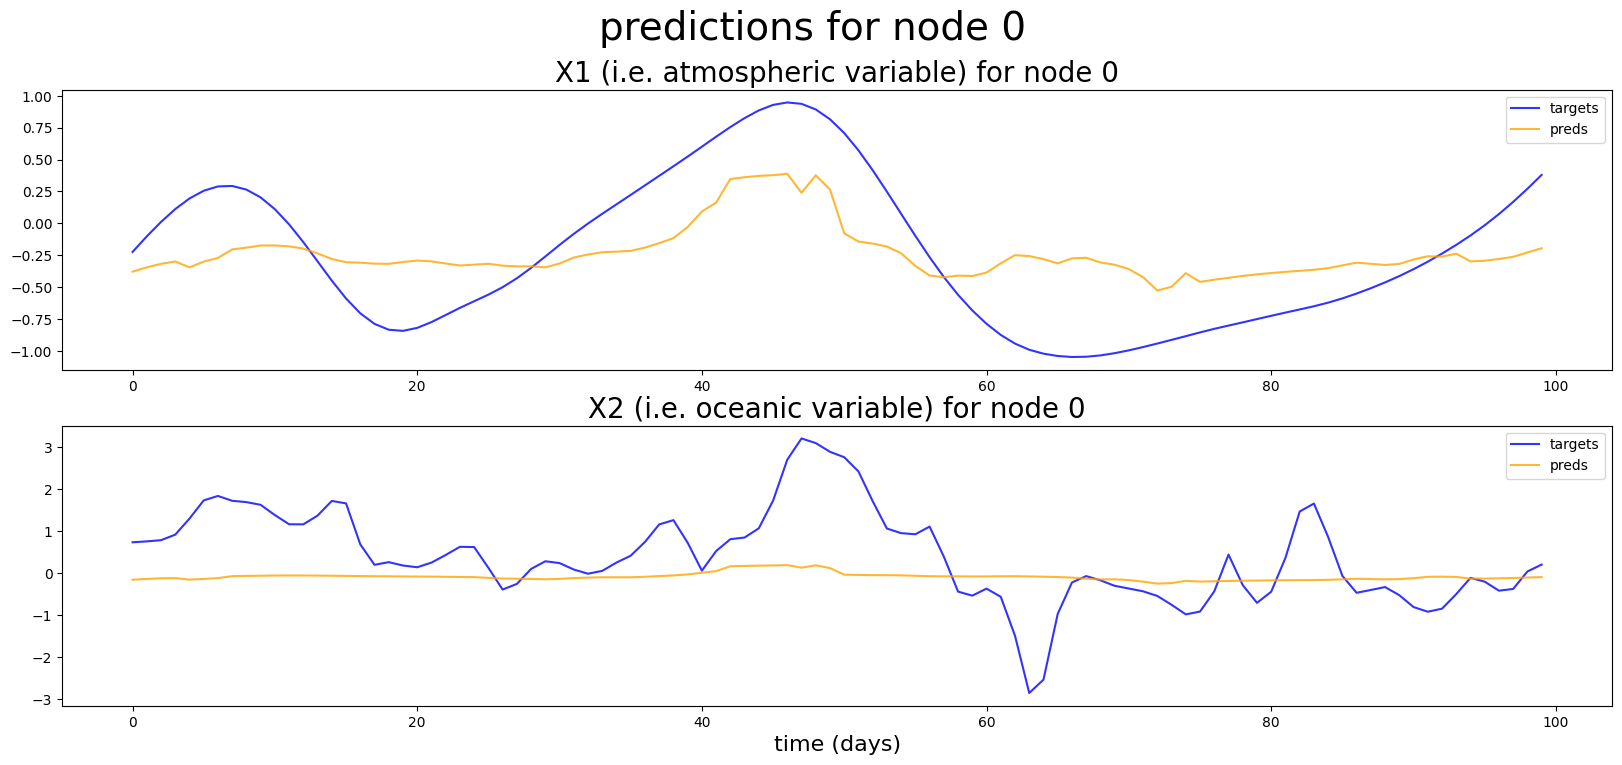

In [16]:
plot_predictions(
    config=get_best_trial_config(study=study11),
    workdir=get_best_trial_workdir(study=study11), # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="train", # i.e. "train"/"val"/"test"
    datasets=datasets,
    plot_all=False, # if false, only plot the first 100 
)

visualize tuning and loss landscape

In [17]:
fig = optuna.visualization.plot_intermediate_values(study11)
fig.show()

In [18]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study11, params=['learning_rate', 'dropout_rate'])
fig.show()

In [19]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study11, params=['learning_rate', 'node_mlp_1_power'])
fig.show()

In [20]:
study11.optimize(objective_partial, 
                n_trials=50-len(study11.trials), 
                n_jobs=1)

[I 2023-12-02 00:05:03,496] Trial 5 pruned. 
[I 2023-12-02 00:05:09,301] Trial 6 pruned. 
[I 2023-12-02 00:19:10,900] Trial 7 finished with value: 0.8869186043739319 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0001483666875842329, 'dropout_rate': 0.5667505784405906, 'activation': 'elu', 'edge_mlp_1_power': 1, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 3, 'node_mlp_2_power': 2}. Best is trial 3 with value: 0.7636350393295288.
[I 2023-12-02 00:34:19,612] Trial 8 finished with value: 0.9278743863105774 and parameters: {'optimizer': 'adam', 'learning_rate': 0.02555773611181906, 'dropout_rate': 0.5128157348552024, 'activation': 'relu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 5, 'node_mlp_2_power': 2}. Best is trial 3 with value: 0.7636350393295288.
[I 2023-12-02 00:48:25,202] Trial 9 finished with value: 0.8218057155609131 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.0011370812023746967, 'momentum': 0.7074409929753972, 'dropout_rate': 0.1889

plot best trial predictions

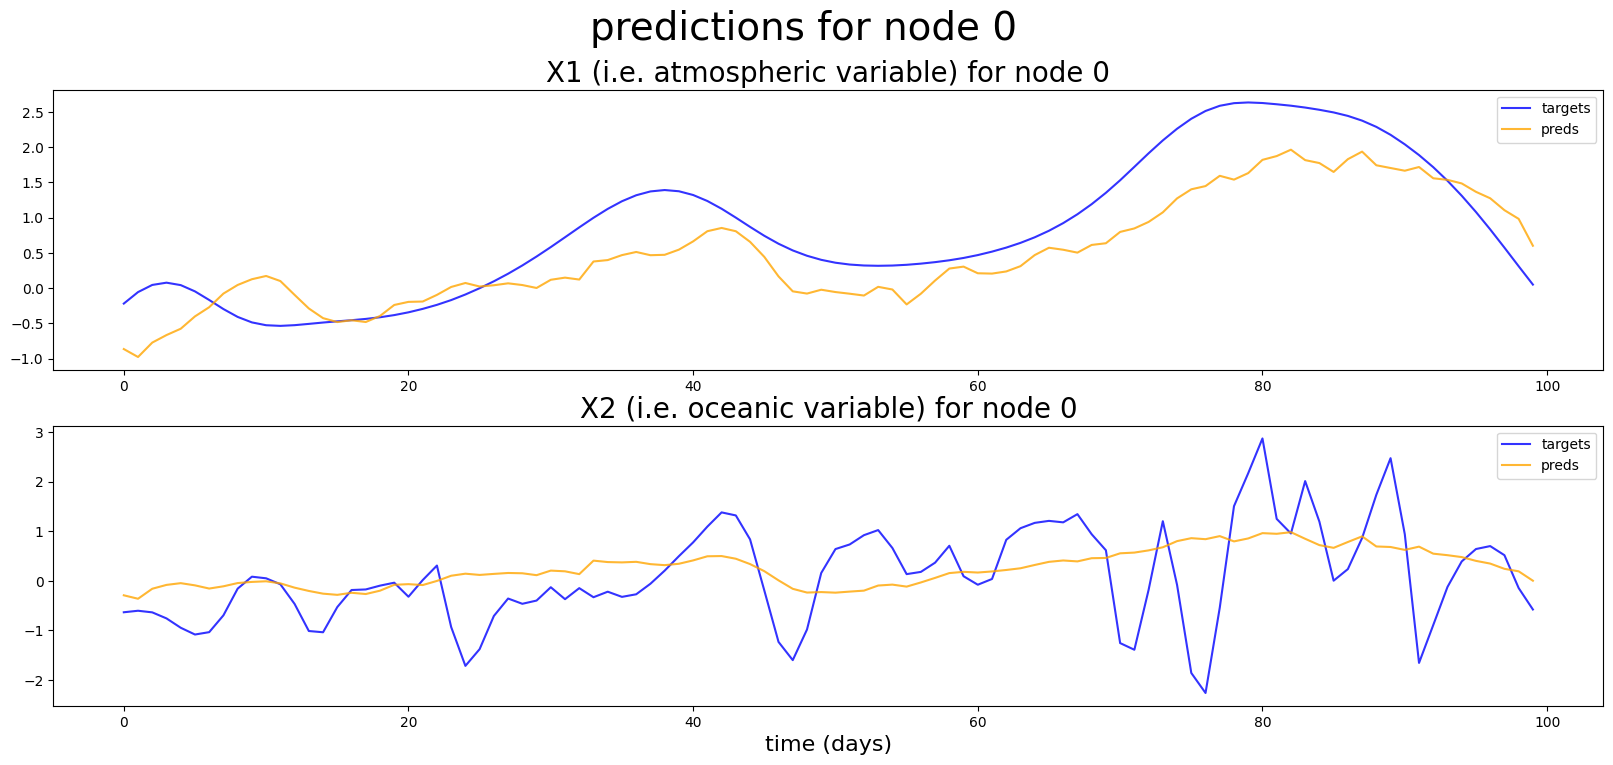

In [22]:
plot_predictions(
    config=get_best_trial_config(study=study11),
    workdir=get_best_trial_workdir(study=study11), # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=datasets,
    plot_all=False, # if false, only plot the first 100 
)

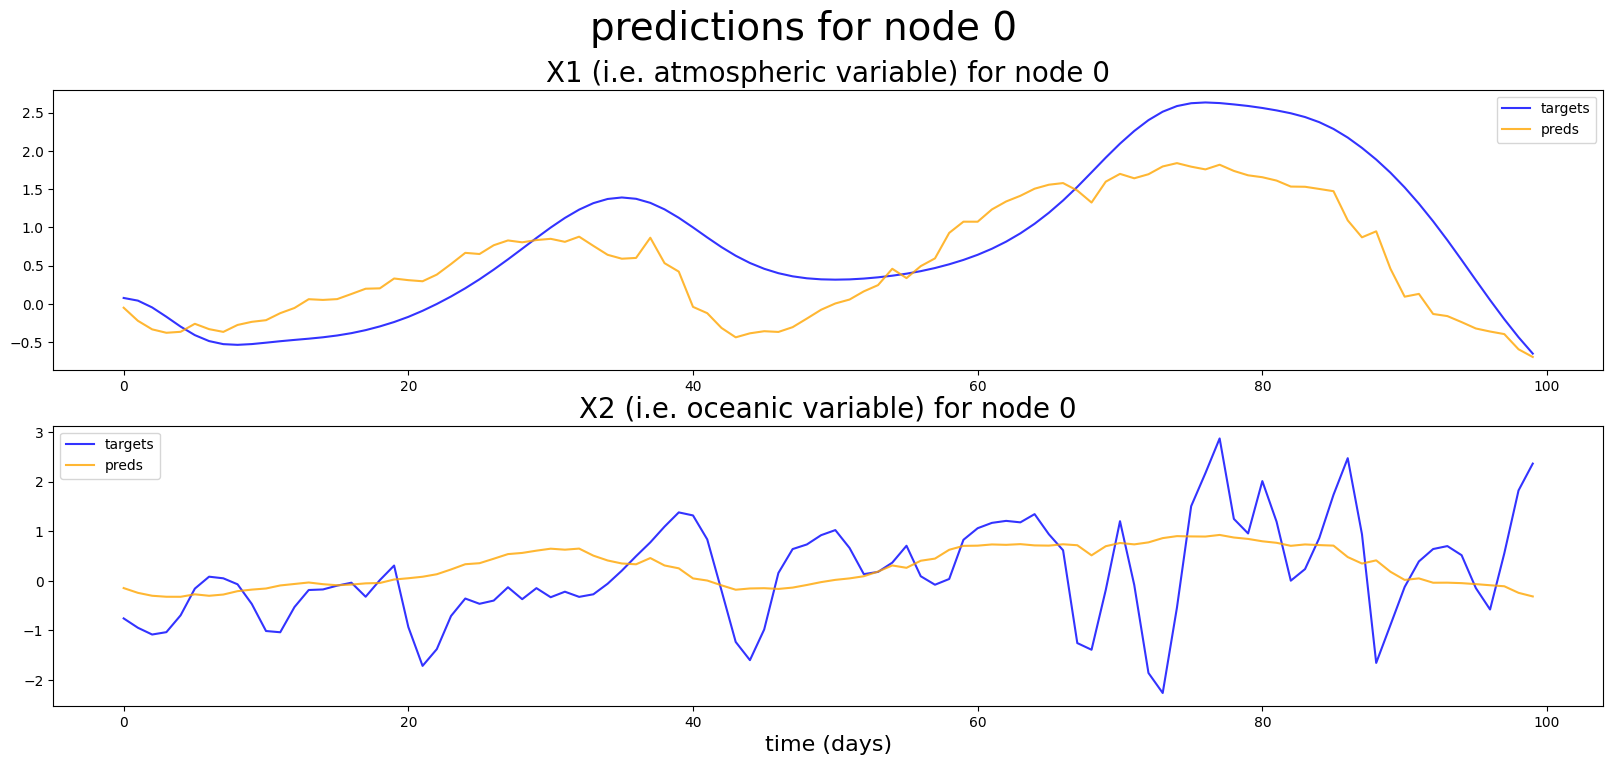

In [26]:
plot_predictions(
    config=get_best_trial_config(study=study11),
    workdir=get_best_trial_workdir(study=study11), # for loading checkpoints 
    plot_ith_rollout_step=3, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=datasets,
    plot_all=False, # if false, only plot the first 100 
)

visualize trials excluding the really bad ones

In [28]:
study_vis = remove_bad_trials(study11)

[I 2023-12-02 16:24:35,287] A new study created in RDB with name: hparam_study_11_trimmed


In [29]:
fig = optuna.visualization.plot_intermediate_values(study_vis)
fig.show()

In [30]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'dropout_rate'])
fig.show()

In [31]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'edge_mlp_1_power'])
fig.show()

In [32]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'node_mlp_1_power'])
fig.show()

In [33]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'optimizer'])

fig.show()

In [34]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['optimizer', 'activation'])
fig.show()

In [35]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['activation', 'node_mlp_1_power'])
fig.show()

In [36]:
study11.optimize(objective_partial, 
                n_trials=200-len(study11.trials), 
                n_jobs=1)

[I 2023-12-02 16:42:16,937] Trial 50 finished with value: 0.42218440771102905 and parameters: {'optimizer': 'adam', 'learning_rate': 0.00034687916366949996, 'dropout_rate': 0.001373568179494755, 'activation': 'elu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 2, 'node_mlp_2_power': 5}. Best is trial 50 with value: 0.42218440771102905.
[I 2023-12-02 16:47:00,662] Trial 51 pruned. 
[W 2023-12-02 16:50:39,776] Trial 52 failed with parameters: {'optimizer': 'adam', 'learning_rate': 0.0005308672228803903, 'dropout_rate': 0.12342917174314069, 'activation': 'elu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 4, 'node_mlp_2_power': 6} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/lorenzvenv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/py/716jgpq538x2wf_s8

KeyboardInterrupt: 

reload objective so we can get the logging during pruning

In [37]:
# get study
study11, objective_partial = prepare_study(study_name="hparam_study_11")

[I 2023-12-02 16:52:20,931] Using an existing study with name 'hparam_study_11' instead of creating a new one.


Number of nodes: 36
Number of edges: 180
Node features shape: (36, 2)
Edge features shape: (180, 1)
Global features shape: (1, 1)


In [38]:
study11.optimize(objective_partial, 
                n_trials=200-len(study11.trials), 
                n_jobs=1)

[I 2023-12-02 17:08:49,381] Trial 53 finished with value: 0.4963351786136627 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0005016244327922381, 'dropout_rate': 0.05500464342718679, 'activation': 'elu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 4, 'node_mlp_2_power': 1}. Best is trial 50 with value: 0.42218440771102905.
[I 2023-12-02 17:25:18,556] Trial 54 finished with value: 0.4297335743904114 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0002810993142408923, 'dropout_rate': 0.00243818795100003, 'activation': 'elu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 2, 'node_mlp_2_power': 4}. Best is trial 50 with value: 0.42218440771102905.
[I 2023-12-02 17:40:44,165] Trial 55 finished with value: 0.5180167555809021 and parameters: {'optimizer': 'adam', 'learning_rate': 0.00032978142979899714, 'dropout_rate': 0.02732039415591129, 'activation': 'elu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 2, 'node

KeyboardInterrupt: 

plot best trial predictions

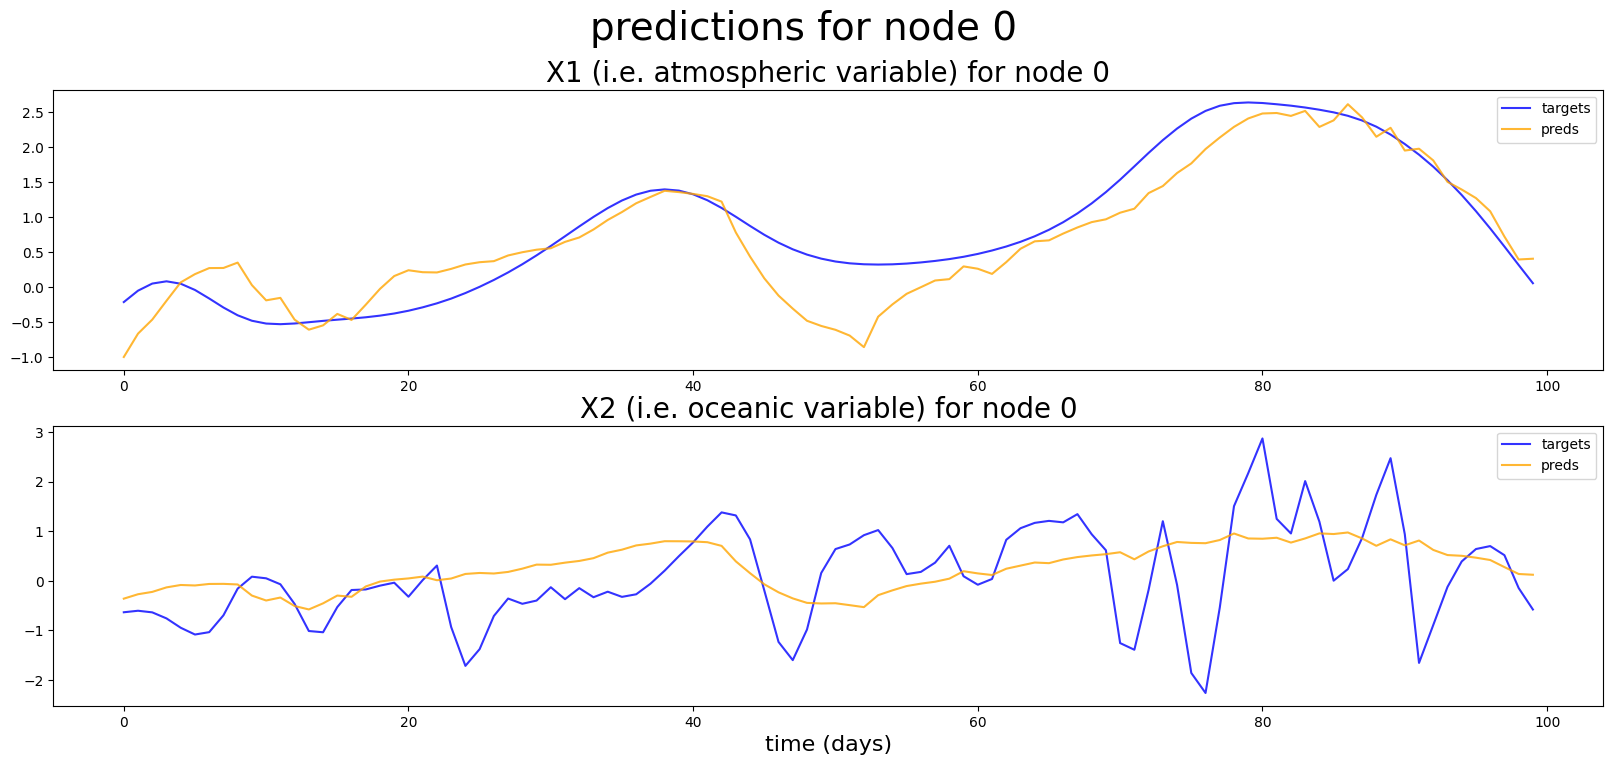

In [39]:
plot_predictions(
    config=get_best_trial_config(study=study11),
    workdir=get_best_trial_workdir(study=study11), # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=datasets,
    plot_all=False, # if false, only plot the first 100 
)

visualize trials excluding the really bad ones

In [43]:
study_vis = remove_bad_trials(study11)

[I 2023-12-03 09:30:02,405] A new study created in RDB with name: hparam_study_11_trimmed


In [44]:
study_vis.trials

[FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.956436276435852], datetime_start=datetime.datetime(2023, 12, 1, 23, 9, 34, 485257), datetime_complete=datetime.datetime(2023, 12, 1, 23, 43, 23, 107385), params={'optimizer': 'adam', 'learning_rate': 0.007021867326771341, 'dropout_rate': 0.21469056683685872, 'activation': 'leaky_relu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 6, 'node_mlp_2_power': 8}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.7018161416053772, 5: 0.9258781671524048, 10: 43.38991928100586, 15: 8.31445026397705, 20: 8.818957328796387, 25: 1.2396728992462158, 30: 1.0304605960845947, 35: 0.9765448570251465, 40: 0.9311666488647461, 45: 12.122129440307617, 50: 15.359703063964844, 55: 1.399962067604065, 60: 10.048823356628418, 65: 7.24931526184082, 70: 18.079967498779297, 75: 4.718255043029785, 80: 62.239627838134766, 85: 8.416083335876465, 90: 1.0039021968841553, 95: 96.88597869873047, 100: 287.8325500488281, 105: 10.1988811

In [45]:
fig = optuna.visualization.plot_intermediate_values(study_vis)
fig.show()

In [46]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'dropout_rate'])
fig.show()

In [47]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'edge_mlp_1_power'])
fig.show()

In [48]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'node_mlp_1_power'])
fig.show()

In [49]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'optimizer'])

fig.show()

In [50]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['optimizer', 'activation'])
fig.show()

In [51]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['activation', 'node_mlp_1_power'])
fig.show()

In [52]:
study11.optimize(objective_partial, 
                n_trials=200-len(study11.trials), 
                n_jobs=1)

[I 2023-12-03 09:57:31,784] Trial 110 finished with value: 0.399099737405777 and parameters: {'optimizer': 'adam', 'learning_rate': 0.000776538448951805, 'dropout_rate': 0.0018150999473010906, 'activation': 'leaky_relu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 8, 'node_mlp_2_power': 3}. Best is trial 108 with value: 0.35665011405944824.
[I 2023-12-03 10:38:04,170] Trial 111 finished with value: 0.40272656083106995 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0008063784053556711, 'dropout_rate': 6.498536162920946e-05, 'activation': 'leaky_relu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 8, 'node_mlp_2_power': 2}. Best is trial 108 with value: 0.35665011405944824.
[I 2023-12-03 11:21:28,344] Trial 112 finished with value: 0.4077787697315216 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0008078115697204336, 'dropout_rate': 0.0014178698858037051, 'activation': 'leaky_relu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 2

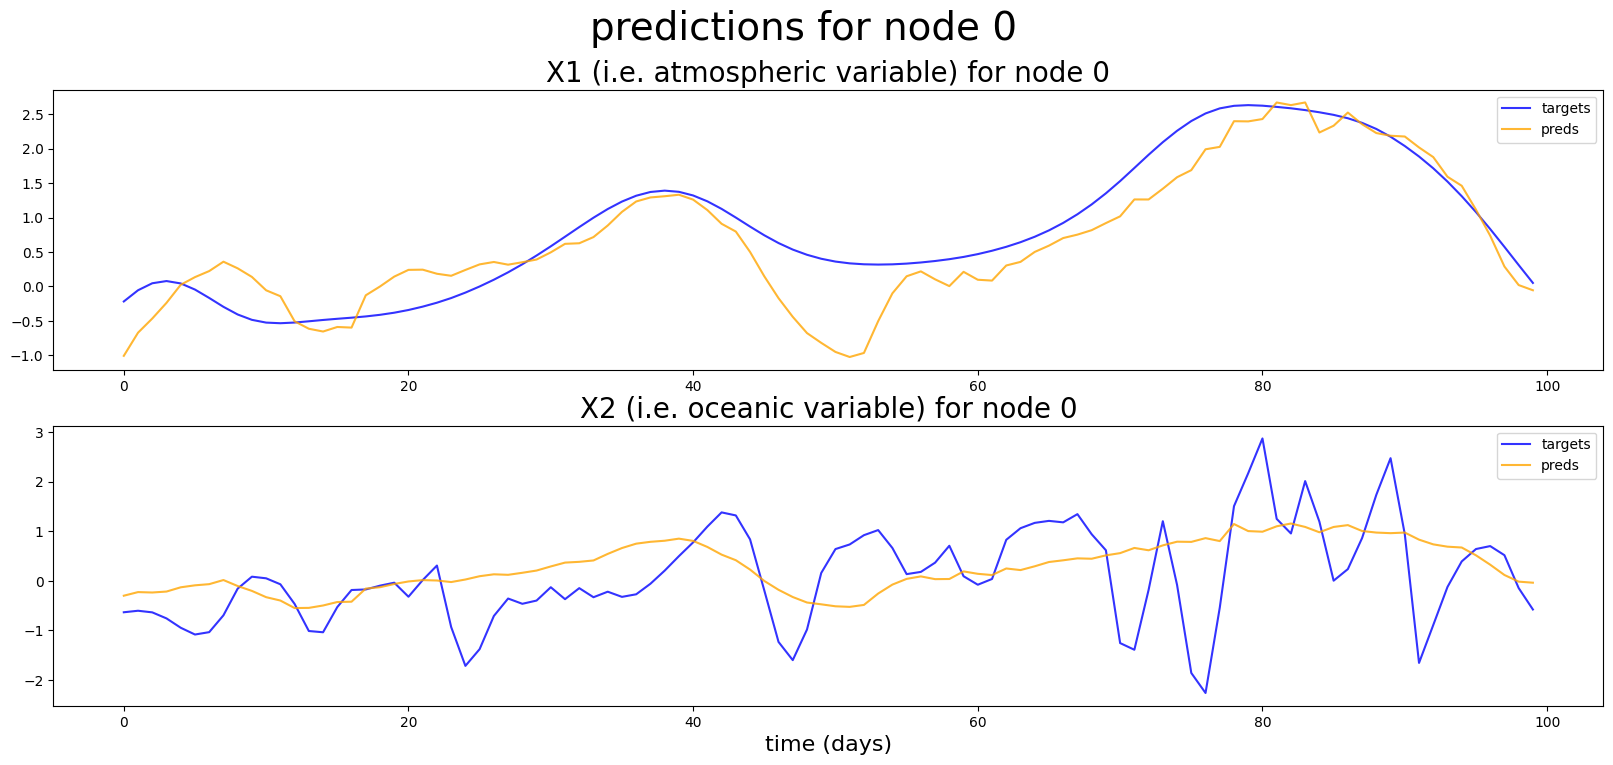

In [53]:
plot_predictions(
    config=get_best_trial_config(study=study11),
    workdir=get_best_trial_workdir(study=study11), # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=datasets,
    plot_all=False, # if false, only plot the first 100 
)

In [54]:
study_vis = remove_bad_trials(study11)

[I 2023-12-05 00:44:36,880] A new study created in RDB with name: hparam_study_11_trimmed


In [57]:
study_vis.trials

[FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.956436276435852], datetime_start=datetime.datetime(2023, 12, 1, 23, 9, 34, 485257), datetime_complete=datetime.datetime(2023, 12, 1, 23, 43, 23, 107385), params={'optimizer': 'adam', 'learning_rate': 0.007021867326771341, 'dropout_rate': 0.21469056683685872, 'activation': 'leaky_relu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 6, 'node_mlp_2_power': 8}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.7018161416053772, 5: 0.9258781671524048, 10: 43.38991928100586, 15: 8.31445026397705, 20: 8.818957328796387, 25: 1.2396728992462158, 30: 1.0304605960845947, 35: 0.9765448570251465, 40: 0.9311666488647461, 45: 12.122129440307617, 50: 15.359703063964844, 55: 1.399962067604065, 60: 10.048823356628418, 65: 7.24931526184082, 70: 18.079967498779297, 75: 4.718255043029785, 80: 62.239627838134766, 85: 8.416083335876465, 90: 1.0039021968841553, 95: 96.88597869873047, 100: 287.8325500488281, 105: 10.1988811

In [55]:
fig = optuna.visualization.plot_intermediate_values(study_vis)
fig.show()

In [56]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis)
fig.show()